# Predicting diabetes in patients

Throughout this module, you dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now, it's time to apply your knowledge.

In this challenge, you'll work with the [Pima Indians Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) from Kaggle. This data was originally collected by the National Institute of Diabetes and Digestive and Kidney Diseases. This dataset contains a subset of patient data from a larger database; in particular, it only contains female patients of Pima Indian heritage over the age of 21.

You will view this dataset through the lens of the following predictive problem: Can you predict the likelihood that a patient has diabetes using various medical diagnostic measurements?


#### Data Dictionary
>- `pregnancies` - Number of times pregnant

>- `glucose` - Plasma glucose concentration - 2 hours in an oral glucose tolerance test

>- `blood_pressure` - Diastolic blood pressure (mm Hg)

>- `skin_thickness` - Triceps skin fold thickness (mm)

>- `insulin` - 2-Hour serum insulin (mu U/ml)

>- `bmi` - Body mass index

>- `diabetes_pedigree` - Diabetes pedigree function

>- `age` - Age (years)

>- `outcome` - Class variable (0 or 1)

In this context:

- **Target/Response:** Outcome, which is 0-1 binary
- **Predictors:** All other columns in the dataset (e.g., Pregnancies, Glucose, etc.), which are all numeric

Your goals in this challenge include validating the data, identifying potential data integrity issues, and identifying basic relationships between the target and provided predictors through EDA.

Your task is to predict the onset of diabetes based on diagnostic measures.

We will start by importing relevant libraries and connecting to the diabetes database.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
from sqlalchemy import create_engine, text
from termcolor import colored
import warnings
import string

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'diabetes'
table_name = 'diabetes'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

with engine.begin() as conn:
    query = text("""SELECT * FROM diabetes""")
    diabetes_df = pd.read_sql_query(query, conn)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

The shape of the data.

In [2]:
print(f"Shape of dataset: {colored(diabetes_df.shape, 'blue')}")

Shape of dataset: (763, 9)


Preview of the first five rows of the data.

In [3]:
diabetes_df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
0,5,44,62,0,0,25.0,0.587,36,0
1,2,56,56,28,45,24.2,0.332,22,0
2,9,57,80,37,0,32.8,0.096,41,0
3,0,57,60,0,0,21.7,0.735,67,0
4,3,61,82,28,0,34.4,0.243,46,0


 Check the number of unique values in each column.

In [4]:
dict = {}
for i in list(diabetes_df.columns):
    dict[i] = diabetes_df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
pregnancies,17
glucose,135
blood_pressure,47
skin_thickness,51
insulin,186
bmi,247
diabetes_pedigree,516
age,52
outcome,2


Separate into features and targets.

In [5]:
con_cols = list(diabetes_df.drop('outcome',axis=1).columns)
target = ['outcome']
print(f"The columns are : {colored(con_cols, 'blue')}")
print(f"The target is   : {colored(target,'blue')}")

The columns are : ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']
The target is   : ['outcome']


Summary statistics.

In [6]:
diabetes_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pregnancies,763.0,3.851900,3.374729,0.000,1.0000,3.000,6.0000,17.00
glucose,763.0,121.686763,30.535641,44.000,99.0000,117.000,141.0000,199.00
blood_pressure,763.0,69.115334,19.399240,0.000,62.0000,72.000,80.0000,122.00
skin_thickness,763.0,20.477064,15.973171,0.000,0.0000,23.000,32.0000,99.00
insulin,763.0,80.292267,115.457448,0.000,0.0000,36.000,128.5000,846.00
bmi,763.0,31.986763,7.893221,0.000,27.3000,32.000,36.5500,67.10
diabetes_pedigree,763.0,0.472477,0.331963,0.078,0.2435,0.374,0.6265,2.42
age,763.0,33.271298,11.772161,21.000,24.0000,29.000,41.0000,81.00
outcome,763.0,0.348624,0.476847,0.000,0.0000,0.000,1.0000,1.00


Are there any missing values?

In [7]:
# for column_name in diabetes_df.columns:
#     print("Unique values in column {} are: {}".format(column_name, diabetes_df[column_name].unique()))
diabetes_df.isnull().sum()

pregnancies          0
glucose              0
blood_pressure       0
skin_thickness       0
insulin              0
bmi                  0
diabetes_pedigree    0
age                  0
outcome              0
dtype: int64

In [8]:
# Print all values that cannot be converted to float
for column_name in ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin',
       'bmi', 'diabetes_pedigree', 'age', 'outcome']:
    print("These are the problematic values for the variable: {}".format(column_name))
    for value in diabetes_df[column_name]:
        try:
            float(value)
        except:
            print(value)

These are the problematic values for the variable: pregnancies
These are the problematic values for the variable: glucose
These are the problematic values for the variable: blood_pressure
These are the problematic values for the variable: skin_thickness
These are the problematic values for the variable: insulin
These are the problematic values for the variable: bmi
These are the problematic values for the variable: diabetes_pedigree
These are the problematic values for the variable: age
These are the problematic values for the variable: outcome


No, there aren't any missing values. Next, we will perform Univariate Analysis and Multivariate Analysis.

### Univariate Analysis

Count target variable.

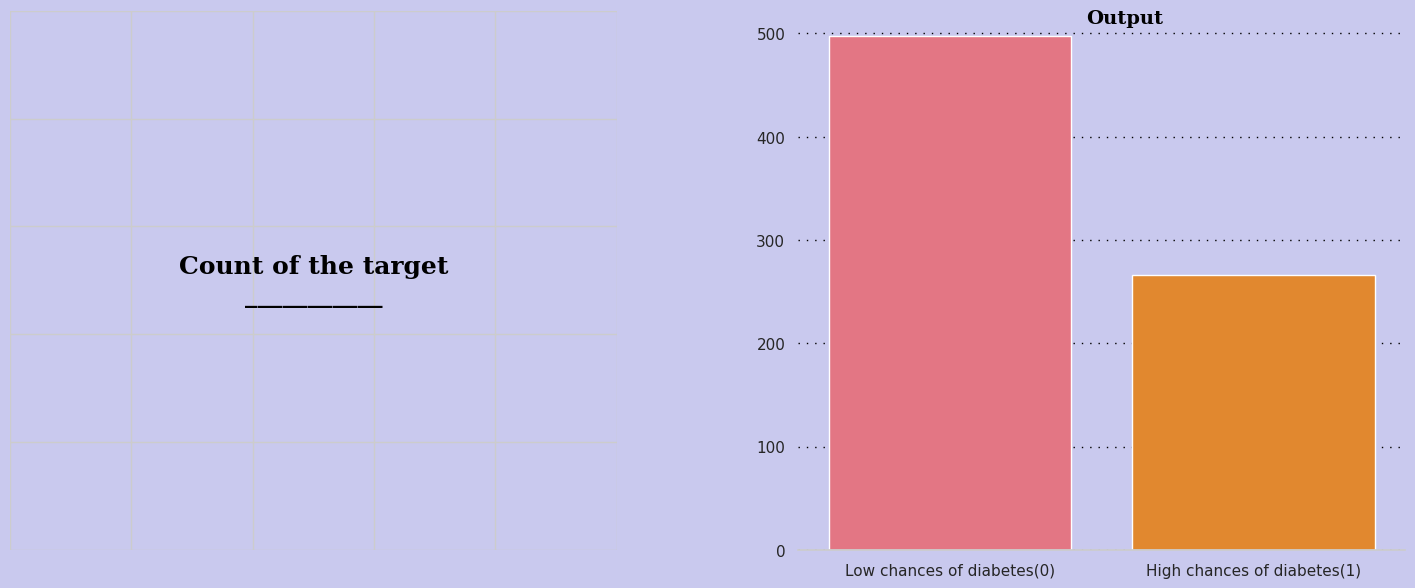

In [9]:
fig = plt.figure(figsize=(18,7))
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

background_color = "#c9c9ee"
color_palette = ["#f56476","#ff8811","#001427","#6369d1","#f0f66e"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# Title of the plot
ax0.text(0.5,0.5,"Count of the target\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')

ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Target Count
ax1.text(0.45,510,"Output",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1, data=diabetes_df, x = 'outcome',palette = color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels(["Low chances of diabetes(0)","High chances of diabetes(1)"])

ax0.spines["top"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)

Boxenplot of features.

In [10]:
def make_boxen_plot(os1,os2,title,dfcol,axisnum,palette):
  axisnum.text(os1, os2, title, fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
  axisnum.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
  sns.boxenplot(ax=axisnum,y=dfcol,palette=[palette],width=0.6)
  axisnum.set_xlabel("")
  axisnum.set_ylabel("")

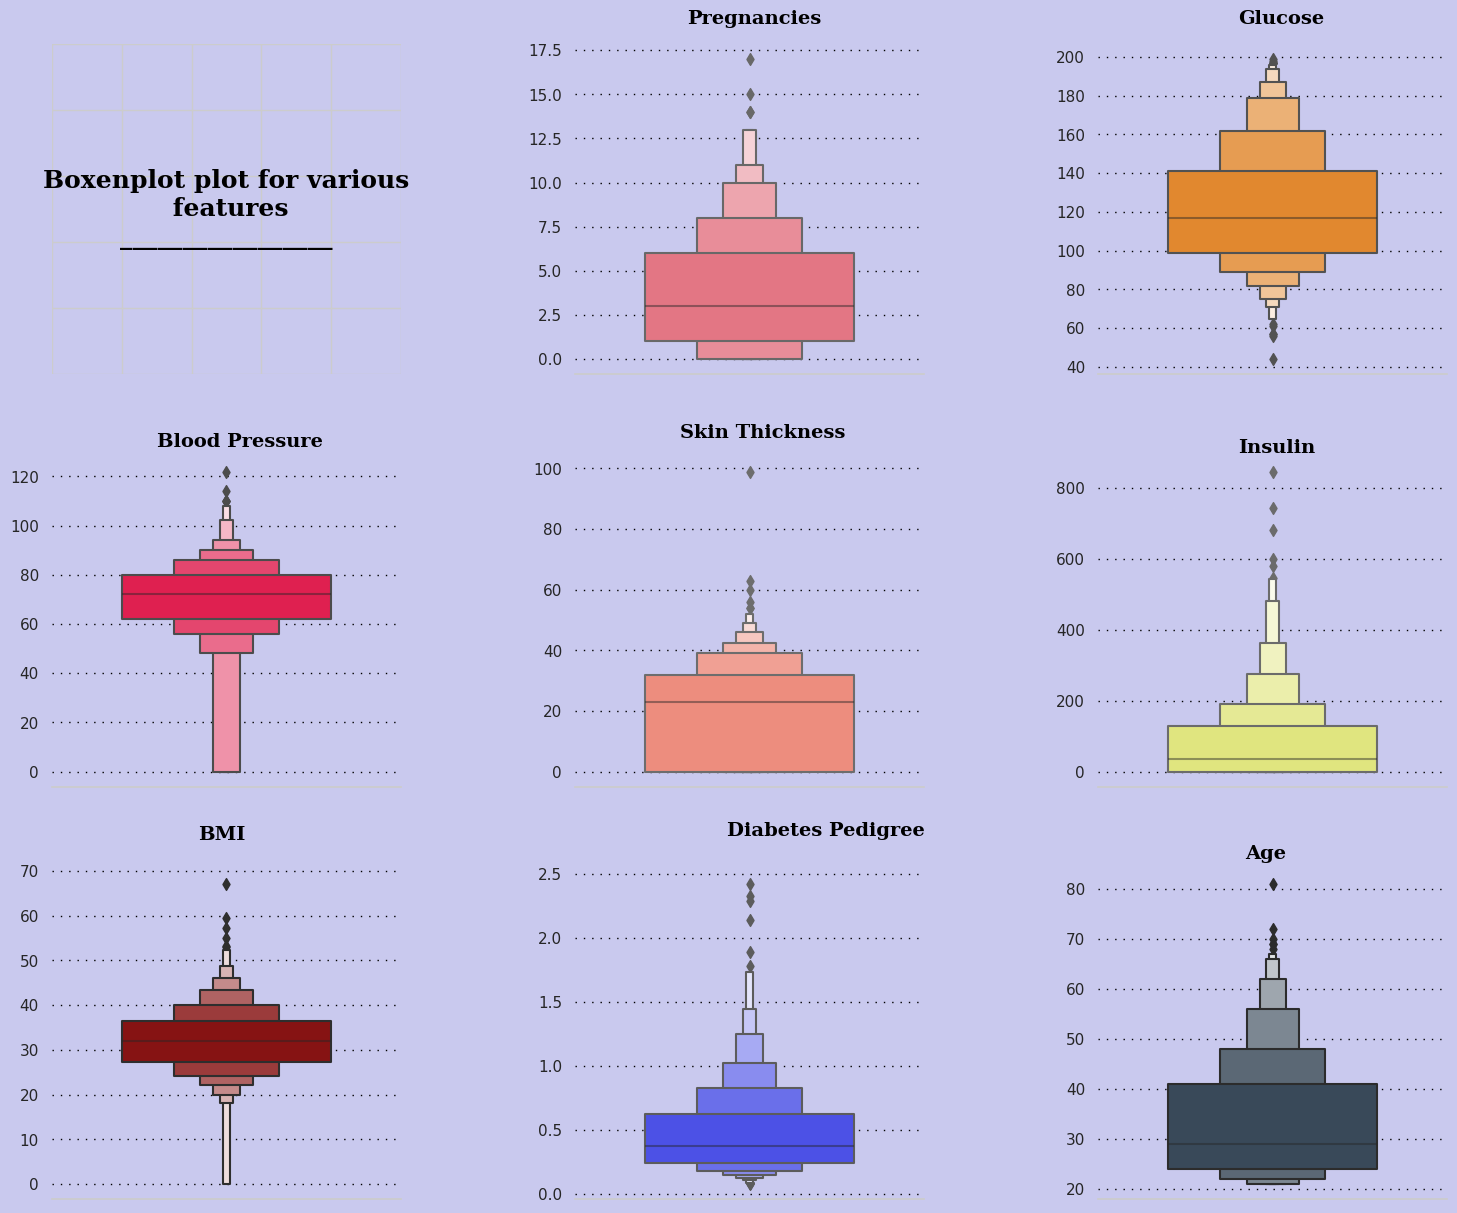

In [11]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#c9c9ee"
# c9c9ee
color_palette = ["#f56476","#ff8811","#ff0040","#ff7f6c","#f0f66e","#990000"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Boxenplot plot for various\n features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

make_boxen_plot(-0.18, 19, 'Pregnancies', diabetes_df['pregnancies'], ax1,"#f56476")
make_boxen_plot(-0.1, 217, 'Glucose', diabetes_df['glucose'], ax2,"#ff8811")
make_boxen_plot(-0.20, 132, 'Blood Pressure', diabetes_df['blood_pressure'], ax3,"#ff0040")
make_boxen_plot(-.2, 110, 'Skin Thickness', diabetes_df['skin_thickness'], ax4,"#ff7f6c")
make_boxen_plot(-0.10, 900, 'Insulin', diabetes_df['insulin'], ax5,"#f0f66e")
make_boxen_plot(-0.08, 77, 'BMI', diabetes_df['bmi'], ax6,"#990000")
make_boxen_plot(-0.065, 2.8, 'Diabetes Pedigree', diabetes_df['diabetes_pedigree'], ax7,"#3339FF")
make_boxen_plot(-0.08, 86, 'Age', diabetes_df['age'], ax8,"#34495E")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

Histogram of features.

In [12]:
def make_histogram(os1,os2,title,dfcol,axisnum,palette):
  axisnum.text(os1, os2, title, fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
  axisnum.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
  sns.histplot(ax=axisnum,x=dfcol,color=palette,kde=True)
  axisnum.set_xlabel("")
  axisnum.set_ylabel("")

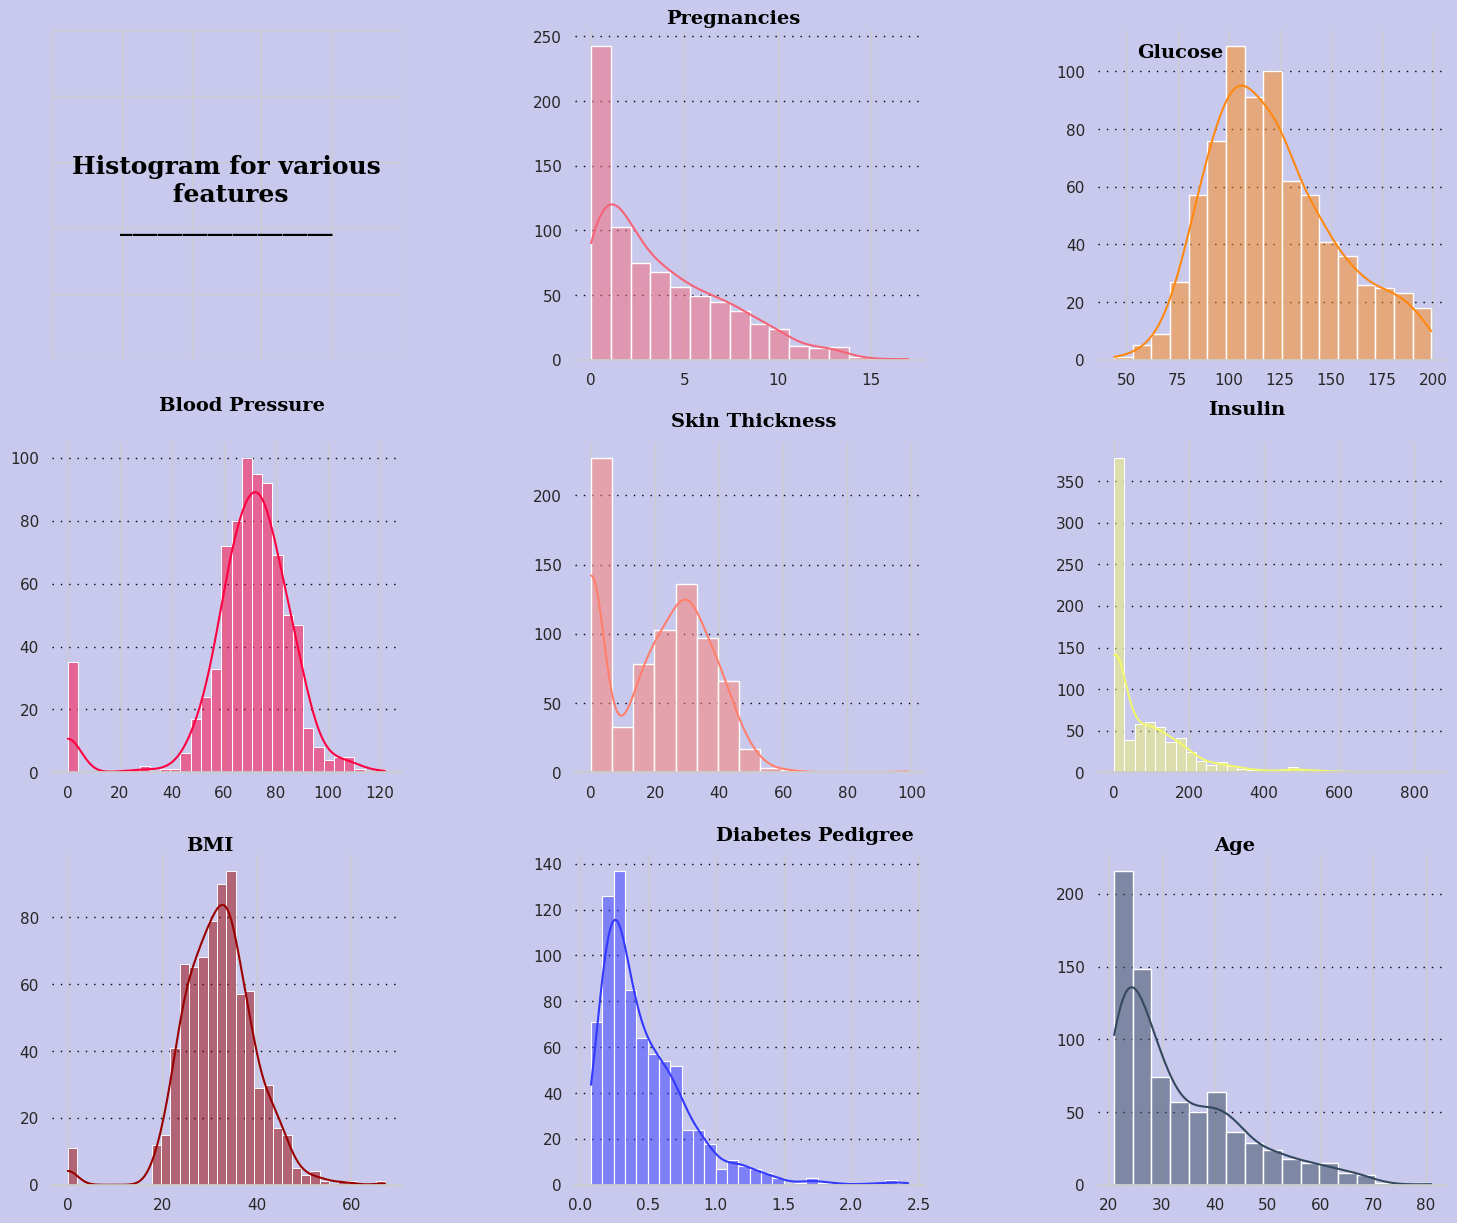

In [13]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#c9c9ee"
# c9c9ee
color_palette = ["#f56476","#ff8811","#ff0040","#ff7f6c","#f0f66e","#990000"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Histogram for various\n features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

make_histogram(4, 260, 'Pregnancies', diabetes_df['pregnancies'], ax1,"#f56476")
make_histogram(55, 105, 'Glucose', diabetes_df['glucose'], ax2,"#ff8811")
make_histogram(35, 115, 'Blood Pressure', diabetes_df['blood_pressure'], ax3,"#ff0040")
make_histogram(25, 250, 'Skin Thickness', diabetes_df['skin_thickness'], ax4,"#ff7f6c")
make_histogram(250, 430, 'Insulin', diabetes_df['insulin'], ax5,"#f0f66e")
make_histogram(25, 100, 'BMI', diabetes_df['bmi'], ax6,"#990000")
make_histogram(1, 150, 'Diabetes Pedigree', diabetes_df['diabetes_pedigree'], ax7,"#3339FF")
make_histogram(40, 230, 'Age', diabetes_df['age'], ax8,"#34495E")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

### Bivariate Analysis

Correlation matrix of features

In [14]:
diabetes_df_corr = diabetes_df.corr().transpose()
diabetes_df_corr

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
pregnancies,1.000000,0.128135,0.140481,-0.082435,-0.074960,0.014874,-0.036063,0.542558,0.218877
glucose,0.128135,1.000000,0.158429,0.075178,0.331550,0.235666,0.137246,0.267136,0.494650
blood_pressure,0.140481,0.158429,1.000000,0.207590,0.088731,0.280781,0.040426,0.239038,0.063602
skin_thickness,-0.082435,0.075178,0.207590,1.000000,0.440858,0.391542,0.183840,-0.114804,0.072382
insulin,-0.074960,0.331550,0.088731,0.440858,1.000000,0.199216,0.184461,-0.043845,0.131870
bmi,0.014874,0.235666,0.280781,0.391542,0.199216,1.000000,0.139227,0.033258,0.289297
diabetes_pedigree,-0.036063,0.137246,0.040426,0.183840,0.184461,0.139227,1.000000,0.030896,0.172292
age,0.542558,0.267136,0.239038,-0.114804,-0.043845,0.033258,0.030896,1.000000,0.235145
outcome,0.218877,0.494650,0.063602,0.072382,0.131870,0.289297,0.172292,0.235145,1.000000


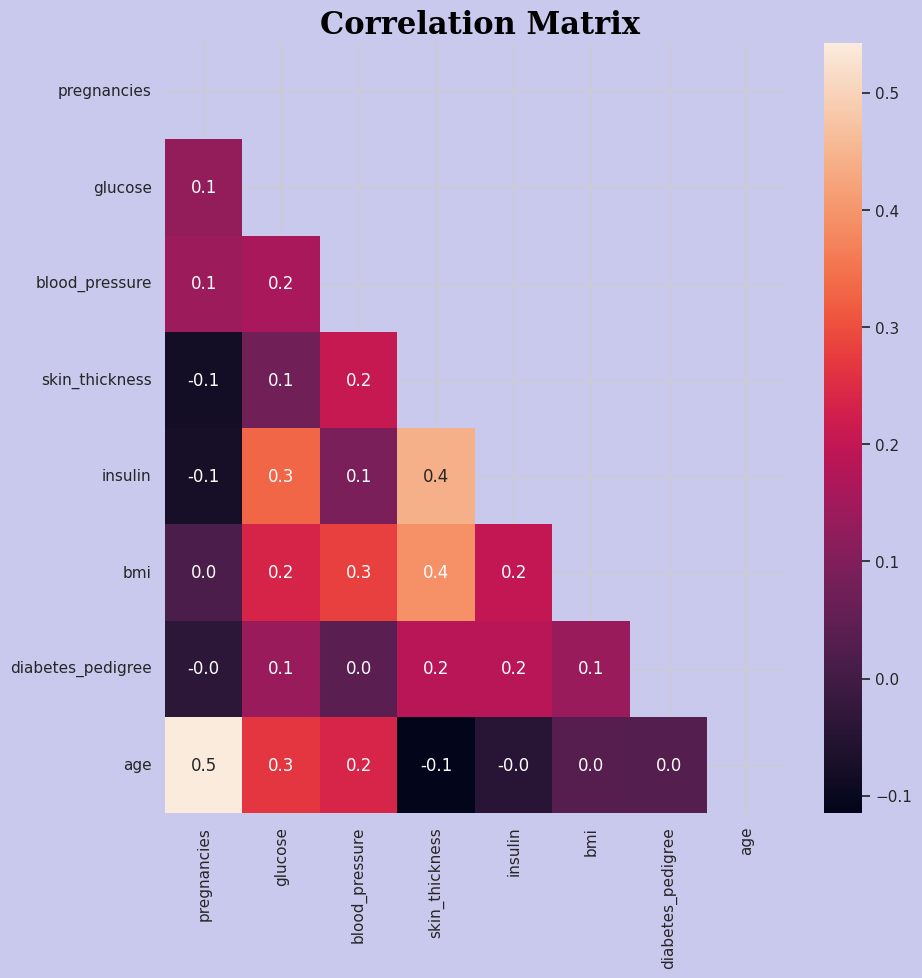

In [15]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)

diabetes_df_corr = diabetes_df[con_cols].corr().transpose()
mask = np.triu(np.ones_like(diabetes_df_corr))
ax0.text(2,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
sns.heatmap(diabetes_df_corr,mask=mask,fmt=".1f",annot=True)
plt.show()

Distribution of features according to target variable.

In [16]:
def make_title(title,axisnum):
  axisnum.text(0.5,0.5,"Distribution of " + title + "\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
  axisnum.spines["bottom"].set_visible(False)
  axisnum.set_xticklabels([])
  axisnum.set_yticklabels([])
  axisnum.tick_params(left=False, bottom=False)

In [17]:
def make_kde_plot(title,axisnum):
  axisnum.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
  sns.kdeplot(ax=axisnum, data=diabetes_df, x=title, hue="outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
  axisnum.set_xlabel("")
  axisnum.set_ylabel("")


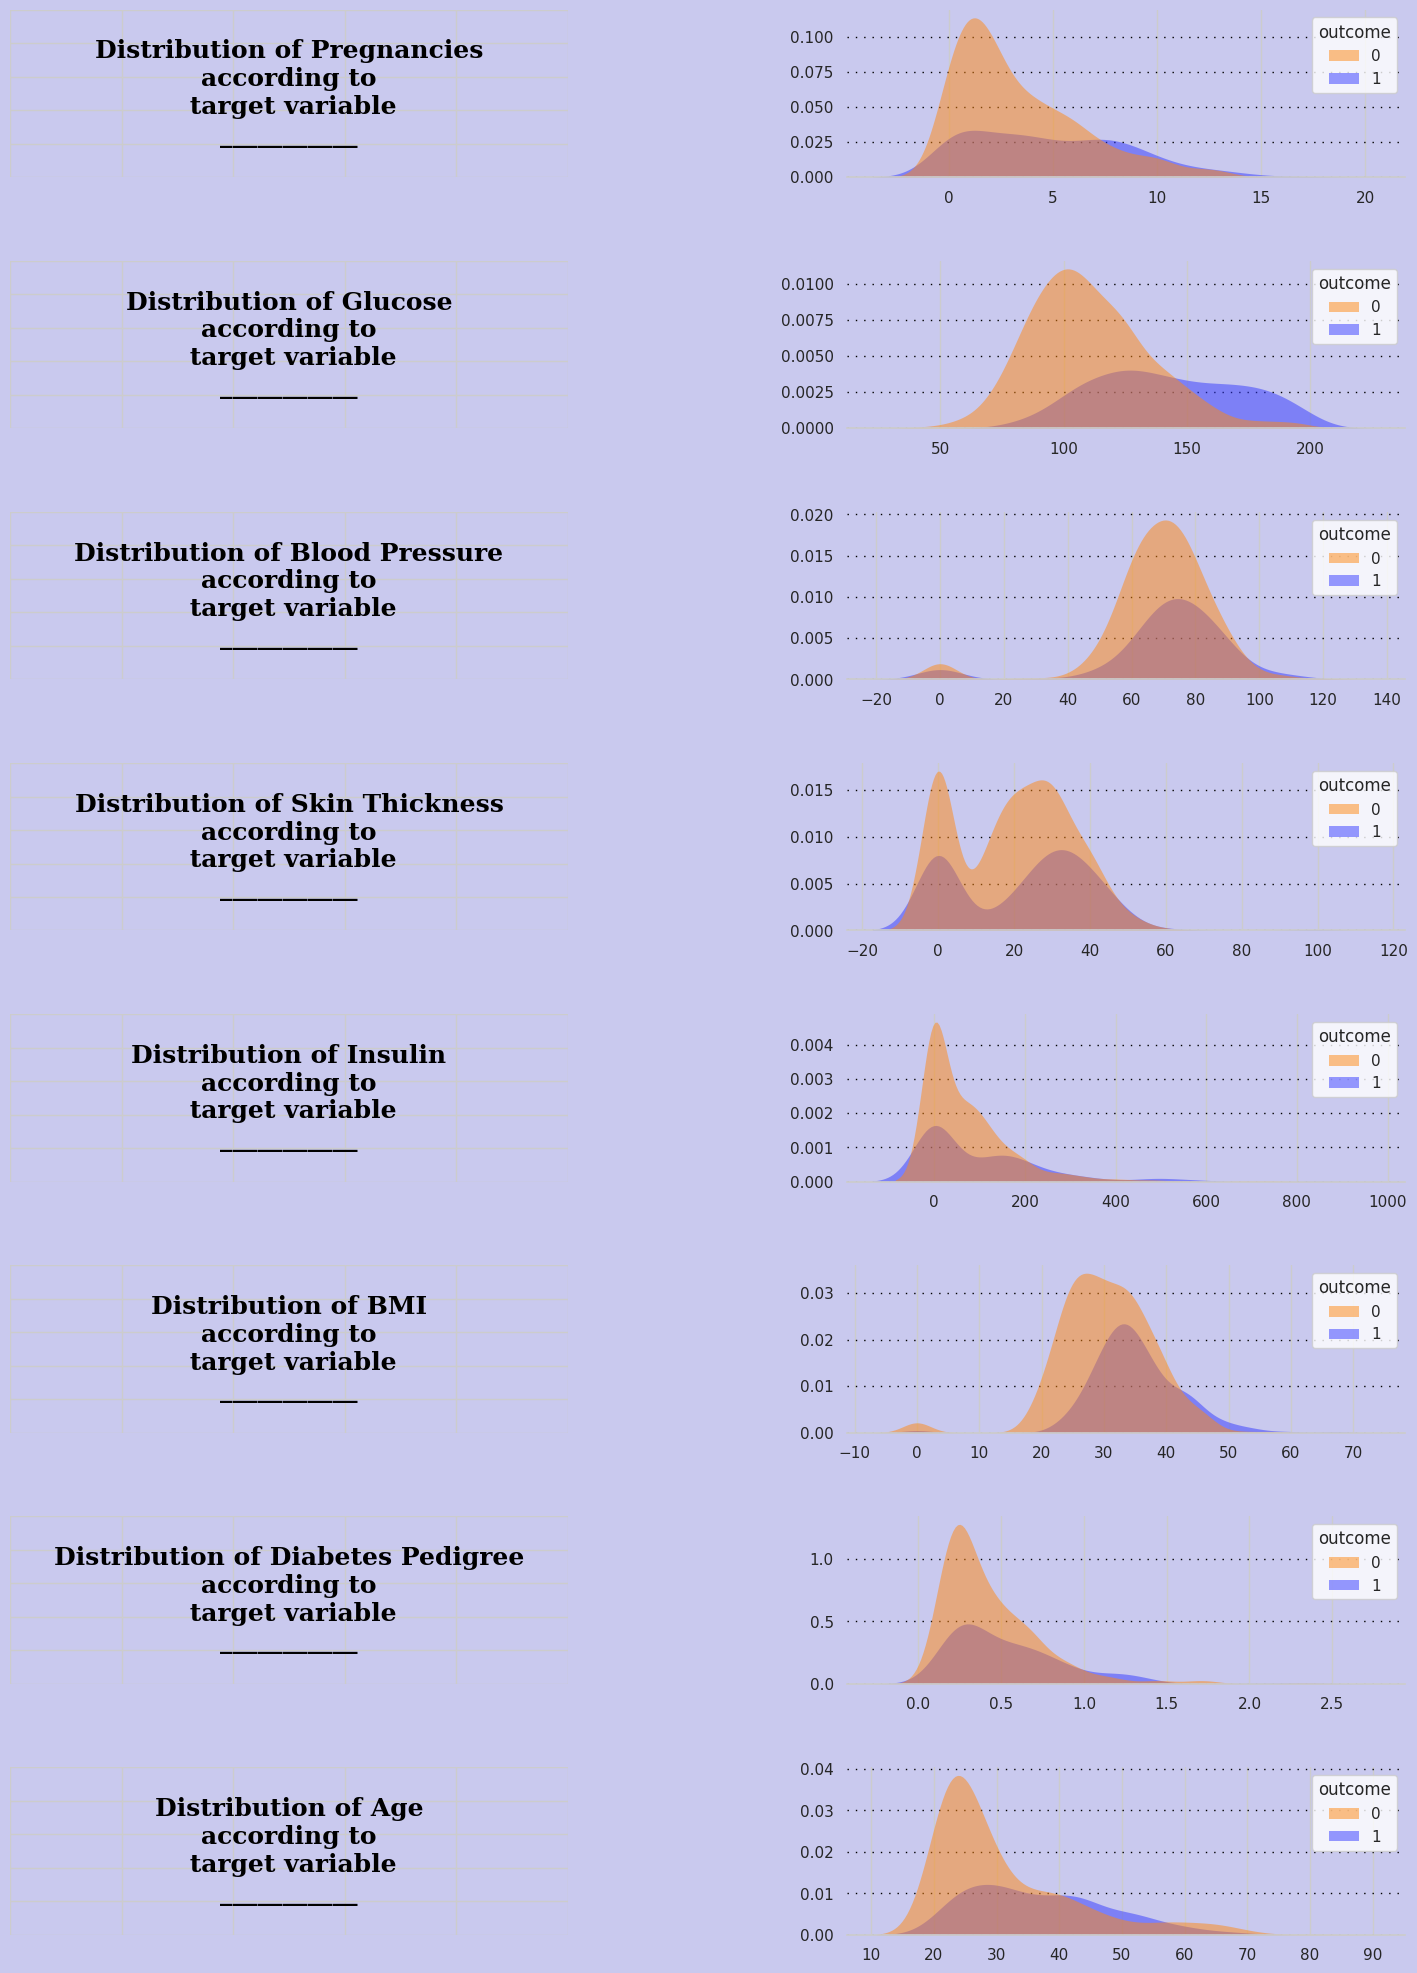

In [18]:
fig = plt.figure(figsize=(18,25))
gs = fig.add_gridspec(8,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])
ax10 = fig.add_subplot(gs[5,0])
ax11 = fig.add_subplot(gs[5,1])
ax12 = fig.add_subplot(gs[6,0])
ax13 = fig.add_subplot(gs[6,1])
ax14 = fig.add_subplot(gs[7,0])
ax15 = fig.add_subplot(gs[7,1])


background_color = "#c9c9ee"
color_palette = ["#f56476","#ff8811","#ff0040","#ff7f6c","#f0f66e","#990000"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)
ax9.set_facecolor(background_color)
ax10.set_facecolor(background_color)
ax11.set_facecolor(background_color)
ax12.set_facecolor(background_color)
ax13.set_facecolor(background_color)
ax14.set_facecolor(background_color)
ax15.set_facecolor(background_color)

make_title('Pregnancies',ax0)
make_kde_plot('pregnancies',ax1)
make_title('Glucose',ax2)
make_kde_plot('glucose',ax3)
make_title('Blood Pressure',ax4)
make_kde_plot('blood_pressure',ax5)
make_title('Skin Thickness',ax6)
make_kde_plot('skin_thickness',ax7)
make_title('Insulin',ax8)
make_kde_plot('insulin',ax9)
make_title('BMI',ax10)
make_kde_plot('bmi',ax11)
make_title('Diabetes Pedigree',ax12)
make_kde_plot('diabetes_pedigree',ax13)
make_title('Age',ax14)
make_kde_plot('age',ax15)

for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)
    ax10.spines[i].set_visible(False)
    ax11.spines[i].set_visible(False)
    ax12.spines[i].set_visible(False)
    ax13.spines[i].set_visible(False)
    ax14.spines[i].set_visible(False)
    ax15.spines[i].set_visible(False)

Pair plot - visualize them all.

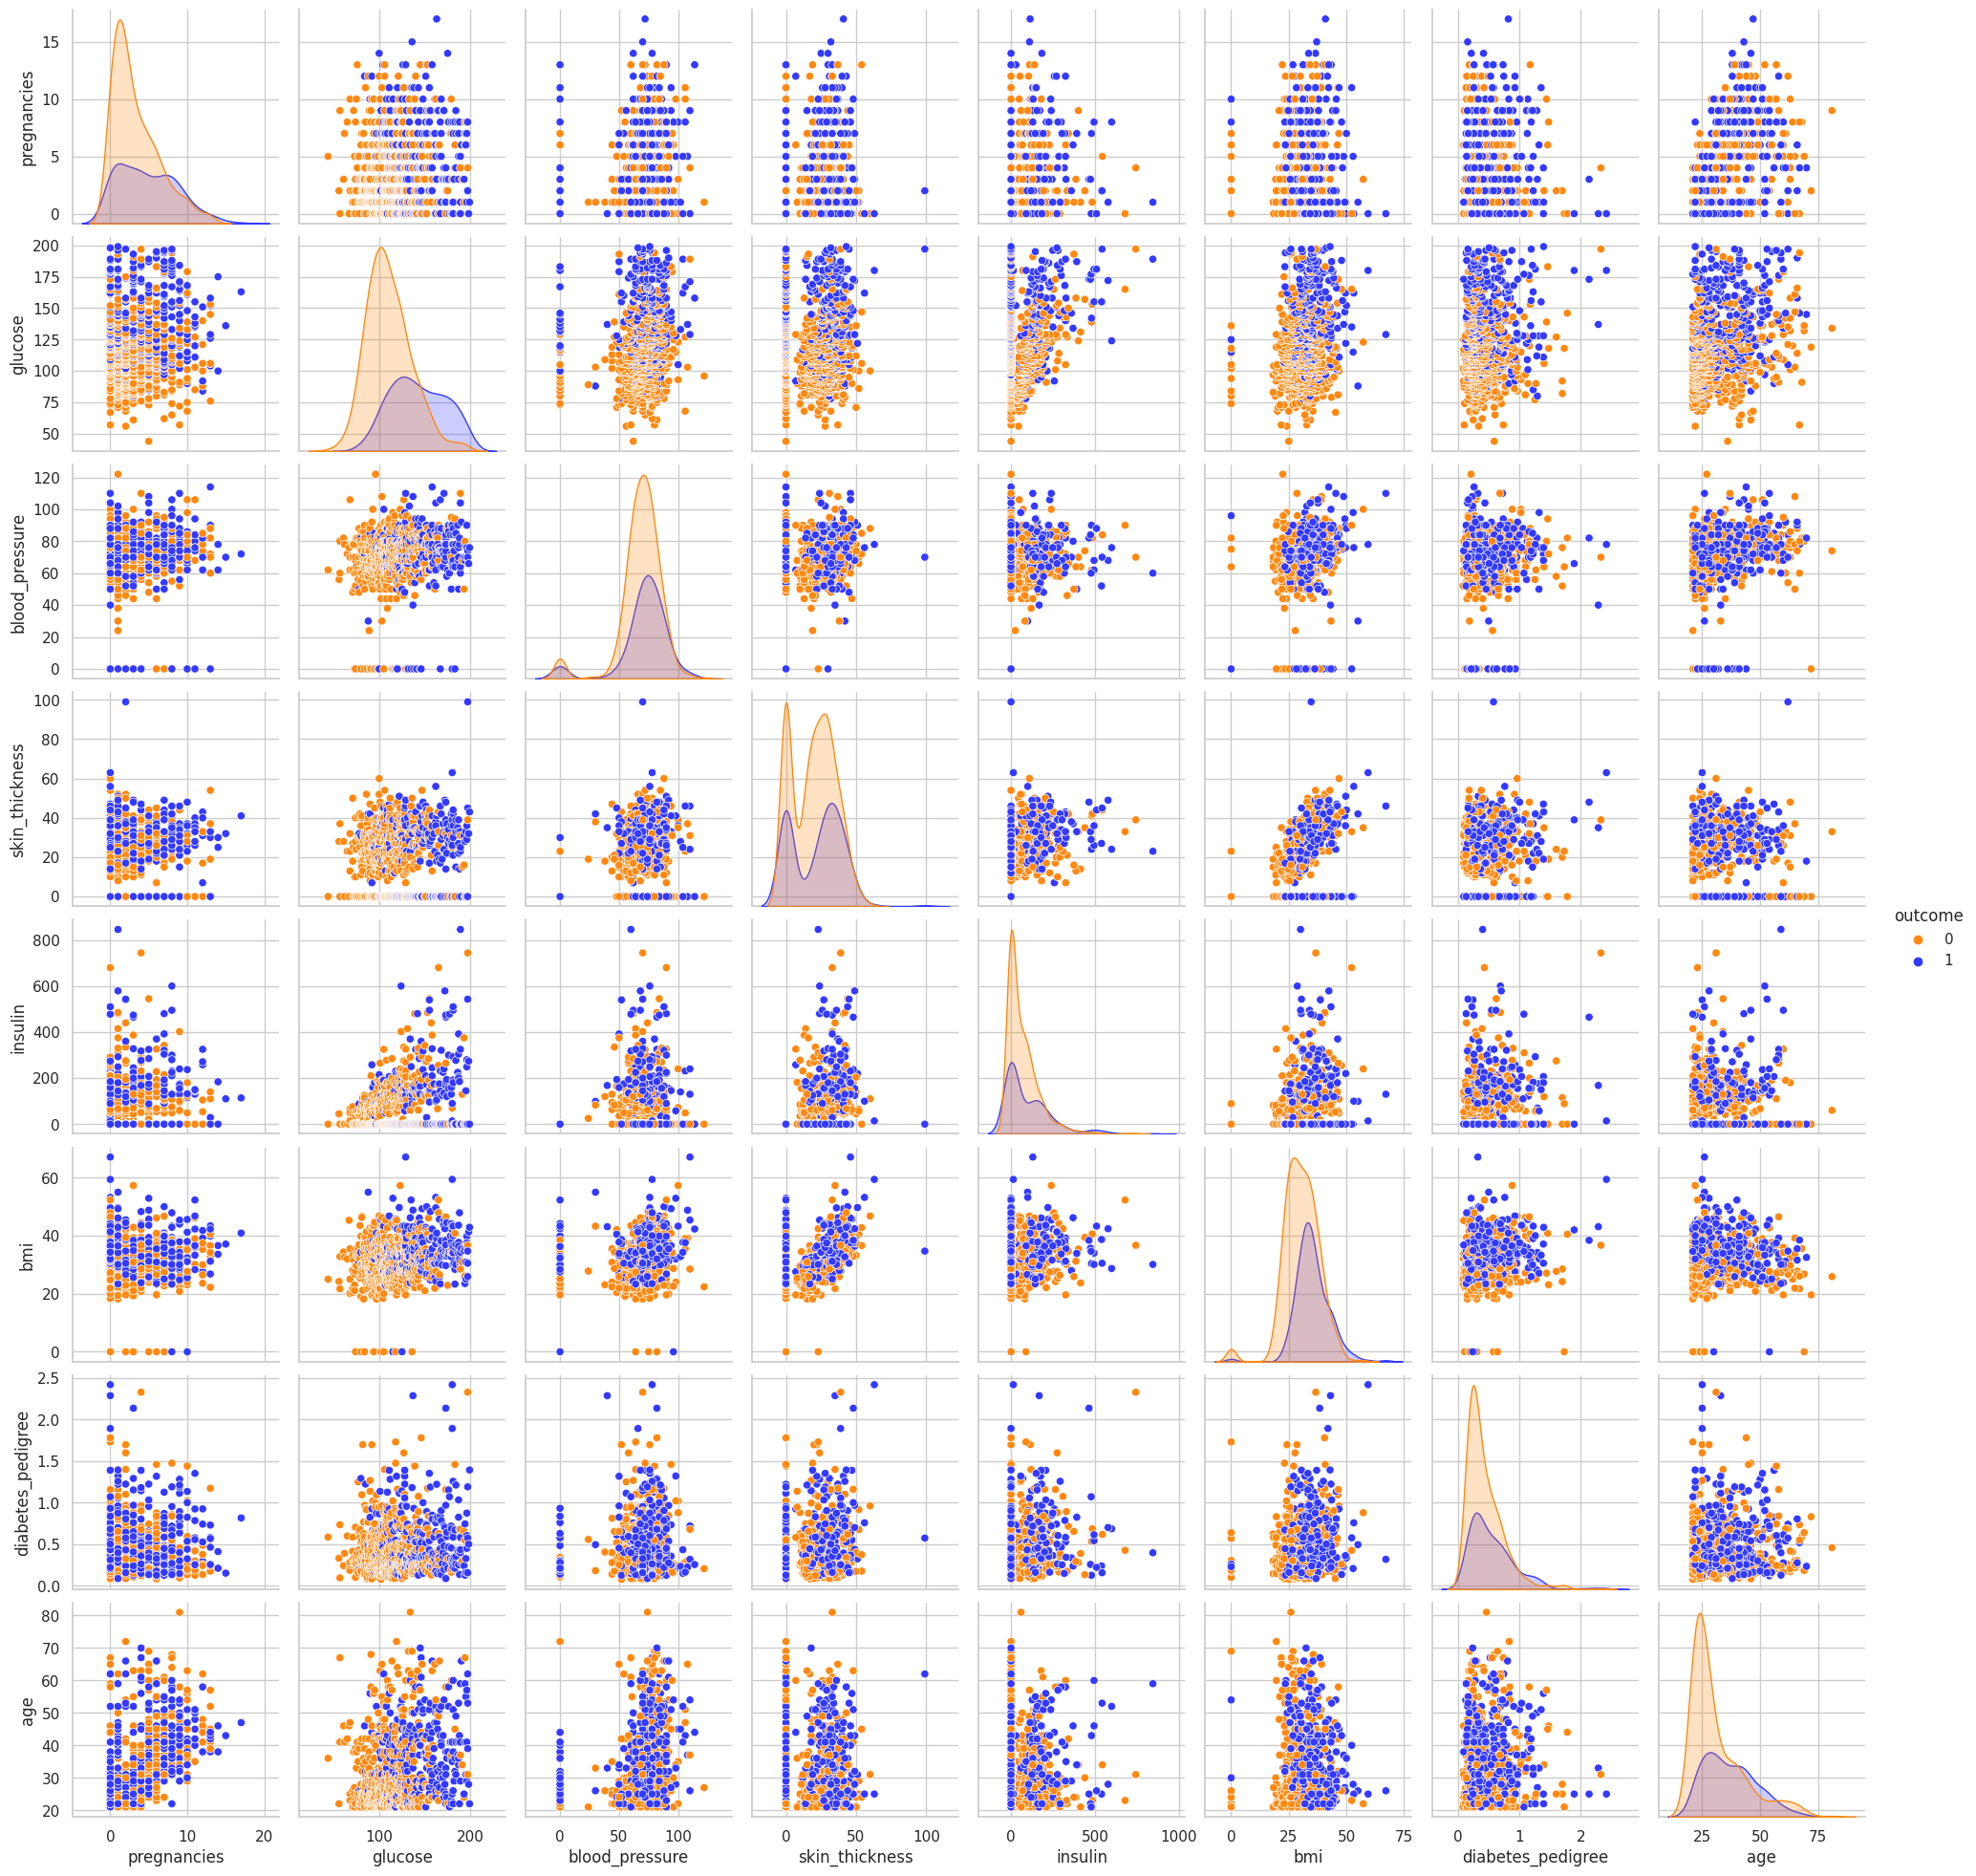

In [19]:
sns.pairplot(diabetes_df,hue='outcome',palette = ["#ff8811","#3339FF"])
plt.show()

Scatter plot of Blood Pressure vs. Glucose vs Age with respect to Outcome.

In [20]:
fig = px.scatter_3d(diabetes_df, x='age', y='glucose', z='blood_pressure',
              color='outcome',size_max=18,color_continuous_scale=["#3339FF", "#ff8811"])
fig.update_layout({"template":"plotly_dark"})
fig.show()

Scatter plot of Glucose vs. Insulin vs. Diabetes Pedigree Function with respect to Outcome.

In [21]:
fig = px.scatter_3d(diabetes_df, x='glucose', y='insulin', z='diabetes_pedigree',
              color='outcome',size_max=18,color_continuous_scale=["#3339FF", "#ff8811"])
fig.update_layout({"template":"plotly_dark"})
fig.show()

### Data Preprocessing

#### Conclusions from EDA

1. There are no NaN values in the data.
2. They are a very less number of outliers in all features.
3. There is no apparent linear correlation between feature variable according to the heatmap.
4. The distribution curve of `insulin` and `diabetes_pedigree` is right skewed.
5. The distribution curve of `glucose` with resepect to `outcome` shows that there are less number of people with high glucose level but they have higher chances of diabetes.
6. The `blood_pressure` lies between 40 and 100, and there are less number of people with diabetes in this range.
7. The pair plots tells the following -
    - Over the `pregnancy` range, females with high glucose have Diabetes.
    - As `insulin` increase, and as `glucose`, there are higher chances of diabetes.
    - As `bmi` increase, and as `glucose`, there are higher chances of diabetes.
    - `Age` alone isn't really an indicator of diabetes.
8. Middle aged people with high `glucose` level and high `blood_pressure` level have higher chances of diabetes which is quite intuitive as well.


### Removing the outliers

The shape of dataset before removing the outliers.

In [22]:
print(f"Shape of dataset: {colored(diabetes_df.shape, 'blue')}")

Shape of dataset: (763, 9)


Remove the outliers and check the shape.

In [23]:
diabetes_df.drop(diabetes_df[diabetes_df["pregnancies"] > 14].index,inplace=True)
diabetes_df.drop(diabetes_df[diabetes_df["glucose"] < 50].index,inplace=True)
diabetes_df.drop(diabetes_df[diabetes_df["blood_pressure"] > 120].index,inplace=True)
diabetes_df.drop(diabetes_df[diabetes_df["skin_thickness"] > 80].index,inplace=True)
diabetes_df.drop(diabetes_df[diabetes_df["insulin"] > 600].index,inplace=True)
diabetes_df.drop(diabetes_df[diabetes_df["bmi"] > 55].index,inplace=True)
diabetes_df.drop(diabetes_df[diabetes_df["diabetes_pedigree"] > 2].index,inplace=True)
diabetes_df.drop(diabetes_df[diabetes_df["age"] > 70].index,inplace=True)

print(f"Shape of dataset: {colored(diabetes_df.shape, 'blue')}")

Shape of dataset: (748, 9)


Alternatively, use winsorization as described in the lesson.

In [24]:
# Arguably 'insulin' and 'diabetes_pedigree' have the strongest outliers
winsorized_insulin = winsorize(diabetes_df['insulin'], (0, 0.10))
winsorized_diabetes_pedigree = winsorize(diabetes_df['diabetes_pedigree'], (0, 0.10))

### Remove the skewness

Checking the distribution of `insulin.`

<Axes: xlabel='insulin', ylabel='Density'>

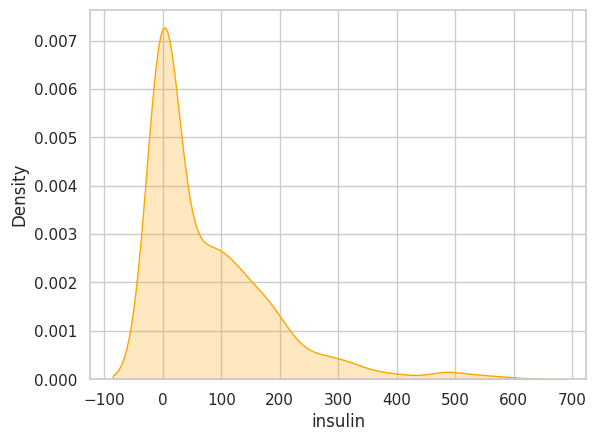

In [25]:
sns.kdeplot(diabetes_df['insulin'],color='Orange',fill=True)

 Removing the skewness using a log function and check the distribution again.

<Axes: xlabel='insulin', ylabel='Density'>

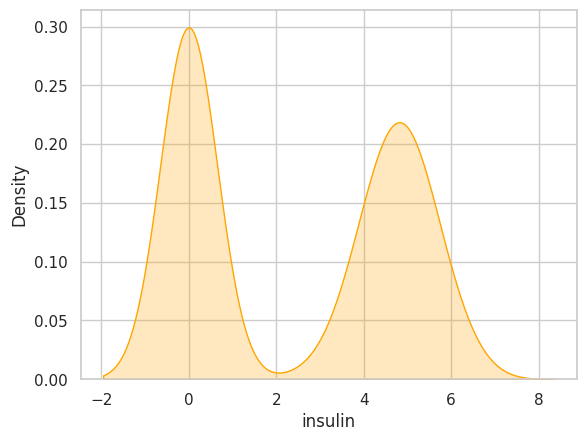

In [26]:
diabetes_df['insulin'] = diabetes_df['insulin'].map(lambda i : np.log(i) if i > 0 else 0)
sns.kdeplot(diabetes_df['insulin'],color='Orange',fill=True)

### Make features model ready

In [27]:
# importing the scaler
from sklearn.preprocessing import StandardScaler

# createa copy of dataframe
diabetes_df2 = diabetes_df
col_cols = list(diabetes_df2.columns)

# removing the target variable from the columns list
col_cols.pop()

# separating the features and target
X = diabetes_df2.drop(['outcome'],axis=1)
y = diabetes_df2[['outcome']]

# instantiate the scaler
scaler = StandardScaler()
X[col_cols] = scaler.fit_transform(X[col_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age
1,-0.555275,-2.166757,-0.679771,0.501024,0.553940,-0.998489,-0.425542,-0.963880
2,1.550025,-2.133530,0.572229,1.077883,-1.001853,0.125547,-1.197310,0.682990
3,-1.156789,-2.133530,-0.471104,-1.293648,-1.001853,-1.325244,0.892351,2.936602
4,-0.254518,-2.000620,0.676563,0.501024,-1.001853,0.334670,-0.716590,1.116377
5,0.948511,-1.967393,0.467896,-1.293648,-1.001853,0.099407,-0.232600,0.682990


### Modeling

In [28]:
!pip install scikit-optimize

Packages.

In [29]:
# Train test split
from sklearn.model_selection import train_test_split

# Base Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Ensembling and Boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Cross Validation
from sklearn.model_selection import cross_val_score

# Hyper-parameter tuning
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Train/test split.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state = 42)
print(f"The shape of X_train is      {colored(X_train.shape,'blue')}")
print(f"The shape of X_test is       {colored(X_test.shape,'blue')}")
print(f"The shape of y_train is      {colored(y_train.shape,'blue')}")
print(f"The shape of y_test is       {colored(y_test.shape,'blue')}")

The shape of X_train is      (598, 8)
The shape of X_test is       (150, 8)
The shape of y_train is      (598, 1)
The shape of y_test is       (150, 1)


Base modeling- Training the data with base models without any hyper-parameter tuning.

In [31]:
models = [
    ('SVC', SVC()),
    ('DecisionTreeClassifier',DecisionTreeClassifier()),
    ('KNeighborsClassifier',KNeighborsClassifier()),
    ('LogisticRegression',LogisticRegression()),
    ('RandomForestClassifier',RandomForestClassifier()),
    ('AdaBoostClassifier',AdaBoostClassifier()),
    ('GradientBoostingClassifier',GradientBoostingClassifier())
]

print("The accuracy scores of the models are :")
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{colored(model_name,'blue')}")
    print(f"{colored(accuracy_score(y_test,y_pred), 'blue')}\n")

The accuracy scores of the models are :
SVC
0.7733333333333333

DecisionTreeClassifier
0.7333333333333333

KNeighborsClassifier
0.68

LogisticRegression
0.8

RandomForestClassifier
0.8066666666666666

AdaBoostClassifier
0.7666666666666667

GradientBoostingClassifier
0.78



Hyperparameter tuning using GridSearchCV -  Decision Tree Classifier tuning.

In [32]:
# define the model
classifier = DecisionTreeClassifier()

# define a grid of parameters
param_grid = {'criterion':['gini','entropy'],
              'splitter':['best','random'],
              'max_depth':[2,3,4,5,6,7,8],
              'max_features':['auto','sqrt','log2'],
             }

# initialize grid search
model = GridSearchCV(
estimator=classifier, param_grid=param_grid, scoring="accuracy", verbose=10,
n_jobs=1,
cv=5 )

# fit the model and extract best score
model.fit(X,y)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5; 1/84] START criterion=gini, max_depth=2, max_features=auto, splitter=best
[CV 1/5; 1/84] END criterion=gini, max_depth=2, max_features=auto, splitter=best;, score=0.653 total time=   0.0s
[CV 2/5; 1/84] START criterion=gini, max_depth=2, max_features=auto, splitter=best
[CV 2/5; 1/84] END criterion=gini, max_depth=2, max_features=auto, splitter=best;, score=0.673 total time=   0.0s
[CV 3/5; 1/84] START criterion=gini, max_depth=2, max_features=auto, splitter=best
[CV 3/5; 1/84] END criterion=gini, max_depth=2, max_features=auto, splitter=best;, score=0.660 total time=   0.0s
[CV 4/5; 1/84] START criterion=gini, max_depth=2, max_features=auto, splitter=best
[CV 4/5; 1/84] END criterion=gini, max_depth=2, max_features=auto, splitter=best;, score=0.631 total time=   0.0s
[CV 5/5; 1/84] START criterion=gini, max_depth=2, max_features=auto, splitter=best
[CV 5/5; 1/84] END criterion=gini, max_depth=2, max_features=auto, 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=10)

In [33]:
print(f"{colored('Decision Tree Classifier', 'blue')}")
print(f"Best score : {colored(model.best_score_,'yellow')}")

print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {colored(best_parameters[param_name],'yellow')}")

Decision Tree Classifier
Best score : 0.7633825503355705
Best parameters set:
	criterion: entropy
	max_depth: 4
	max_features: sqrt
	splitter: random


K Neighbors Classifier tuning.

In [34]:
# define the model
classifier = KNeighborsClassifier()

# define a grid of parameters
param_grid = {'n_neighbors':[2,3,4,5,6,7,8],
              'weights':['uniform','distance'],
              'algorithm':['auto','ball_tree','kd_tree','brute'],
              'leaf_size':[26,27,28,29,30,31]
             }

# initialize grid search
model = GridSearchCV(
estimator=classifier, param_grid=param_grid, scoring="accuracy", verbose=10,
n_jobs=1,
cv=5 )

# fit the model and extract best score
model.fit(X,y)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5; 1/336] START algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform
[CV 1/5; 1/336] END algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform;, score=0.680 total time=   0.0s
[CV 2/5; 1/336] START algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform
[CV 2/5; 1/336] END algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform;, score=0.687 total time=   0.0s
[CV 3/5; 1/336] START algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform
[CV 3/5; 1/336] END algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 4/5; 1/336] START algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform
[CV 4/5; 1/336] END algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform;, score=0.658 total time=   0.0s
[CV 5/5; 1/336] START algorithm=auto, leaf_size=26, n_neighbors=2, weights=uniform
[CV 5/5; 1/336] END algorithm=auto, leaf_size=26, n_neighbors=2, 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [26, 27, 28, 29, 30, 31],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=10)

In [35]:
print(f"{colored('K Neighbors Classifier', 'blue')}")
print(f"Best score : {colored(model.best_score_,'yellow')}")

print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {colored(best_parameters[param_name],'yellow')}")

K Neighbors Classifier
Best score : 0.6737091722595079
Best parameters set:
	algorithm: auto
	leaf_size: 26
	n_neighbors: 7
	weights: uniform


### PCA Analysis

Normalize and visualize our covariance matrix.

In [40]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(diabetes_df)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns. So transpose `X`.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00133869  0.13576207  0.14993316 -0.08699072 -0.16005483  0.02652396
  -0.02206626  0.55661814  0.22248078]
 [ 0.13576207  1.00133869  0.16338918  0.03465792  0.10307584  0.22290715
   0.09938046  0.26864859  0.49416674]
 [ 0.14993316  0.16338918  1.00133869  0.20707676  0.08669699  0.27094879
   0.05552015  0.27588391  0.06479936]
 [-0.08699072  0.03465792  0.20707676  1.00133869  0.57822664  0.37578388
   0.15233317 -0.13365835  0.04923324]
 [-0.16005483  0.10307584  0.08669699  0.57822664  1.00133869  0.14412824
   0.16635354 -0.18261552  0.00343368]
 [ 0.02652396  0.22290715  0.27094879  0.37578388  0.14412824  1.00133869
   0.10335381  0.05927807  0.28446984]
 [-0.02206626  0.09938046  0.05552015  0.15233317  0.16635354  0.10335381
   1.00133869  0.04191974  0.16692897]
 [ 0.55661814  0.26864859  0.27588391 -0.13365835 -0.18261552  0.05927807
   0.04191974  1.00133869  0.24189885]
 [ 0.22248078  0.49416674  0.06479936  0.04923324  0.00343368  0.28446984
  

Next, calculate eigenvectors and eigenvalues, which allow us to better understand how to transform the covariance matrix.

In [41]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.30433689 -0.43855894 -0.34211365 -0.23478448 -0.14796144 -0.38376863
 -0.19765253 -0.37155297 -0.44338531]
Eigenvalue 1: 2.243394091337734
----------------------------------------
Eigenvector 2: 
[-0.39810626 -0.06398931  0.04289581  0.53587734  0.53000617  0.24011317
  0.17289782 -0.41326259 -0.09576895]
Eigenvalue 2: 1.9620994768132378
----------------------------------------
Eigenvector 3: 
[ 0.28617762 -0.40448968  0.54762288  0.23460442  0.06117348  0.05739087
 -0.2930593   0.25151873 -0.49333465]
Eigenvalue 3: 1.1244242057555878
----------------------------------------
Eigenvector 4: 
[ 0.22711463 -0.22414593 -0.07212624  0.0278081   0.17536972 -0.39314954
  0.80128974  0.20967746 -0.14439906]
Eigenvalue 4: 0.9341588105303759
----------------------------------------
Eigenvector 5: 
[ 0.35915419  0.16405744 -0.40942759  0.2275984   0.51348395 -0.40066863
 -0.42908276  0.11409872  0.05770437]
Eigenvalue 5: 0.817824004992029
--------------------------------------

The highest-correlated component will explain about 24.8% of the overall data's variance. Next, we visualize the data through the *scree plot*.

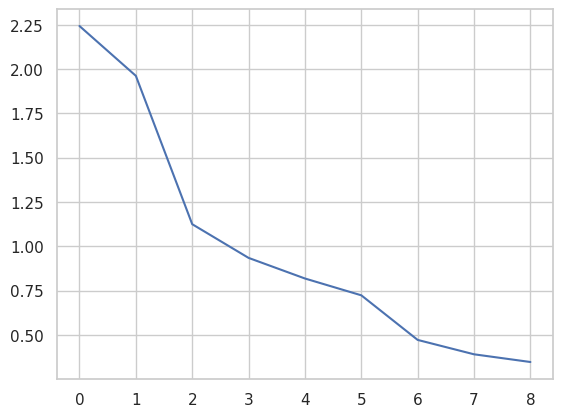

[2.24339409 1.96209948 1.12442421 0.93415881 0.817824   0.7229074
 0.47104742 0.38985044 0.34634234]


In [42]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

This tells use that the variance is contained inside the first six components. We could have simplied these steps by using functions from Matplotlib and scikit-learn.

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.24893277 0.21771959 0.124769   0.10365666 0.09074785 0.08021566]


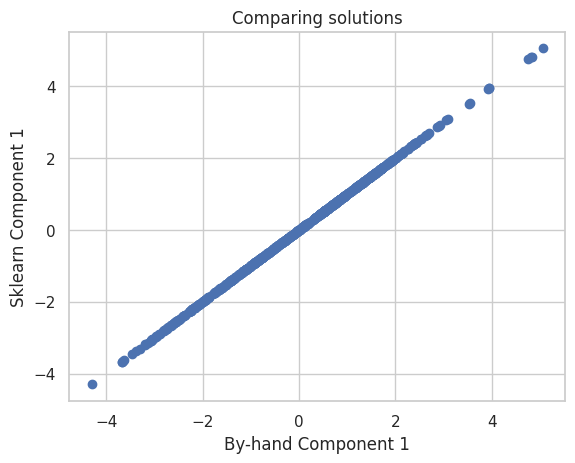

In [43]:
sklearn_pca = PCA(n_components=6)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()